In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from pycaret.classification import ClassificationExperiment
from pycaret.classification import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from datetime import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet['pet_size'].unique()

array(['small', 'large', 'extra_small', 'medium', 'extra_large'],
      dtype=object)

In [4]:
datasheet = datasheet.drop([
    'vendor_id', 
    # 'rating',
    # 'sales',
    # 'price',
    'country',
    # 're_buy',
    # 'VAP'
], axis=1)
datasheet.head()

,product_category,sales,price,VAP,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,
5040,Equipment,123,7293,0,small,fish,7,1
4567,Toys,61,9304,1,small,cat,10,0
4237,Toys,218,8180,0,small,hamster,6,0
4364,Snack,69,18559,1,large,dog,1,1
4184,Supplements,138,10283,1,large,dog,10,0


In [5]:
datasheet['pet_type'].unique()

array(['fish', 'cat', 'hamster', 'dog', 'bird', 'rabbit'], dtype=object)

### Plotting for analysis

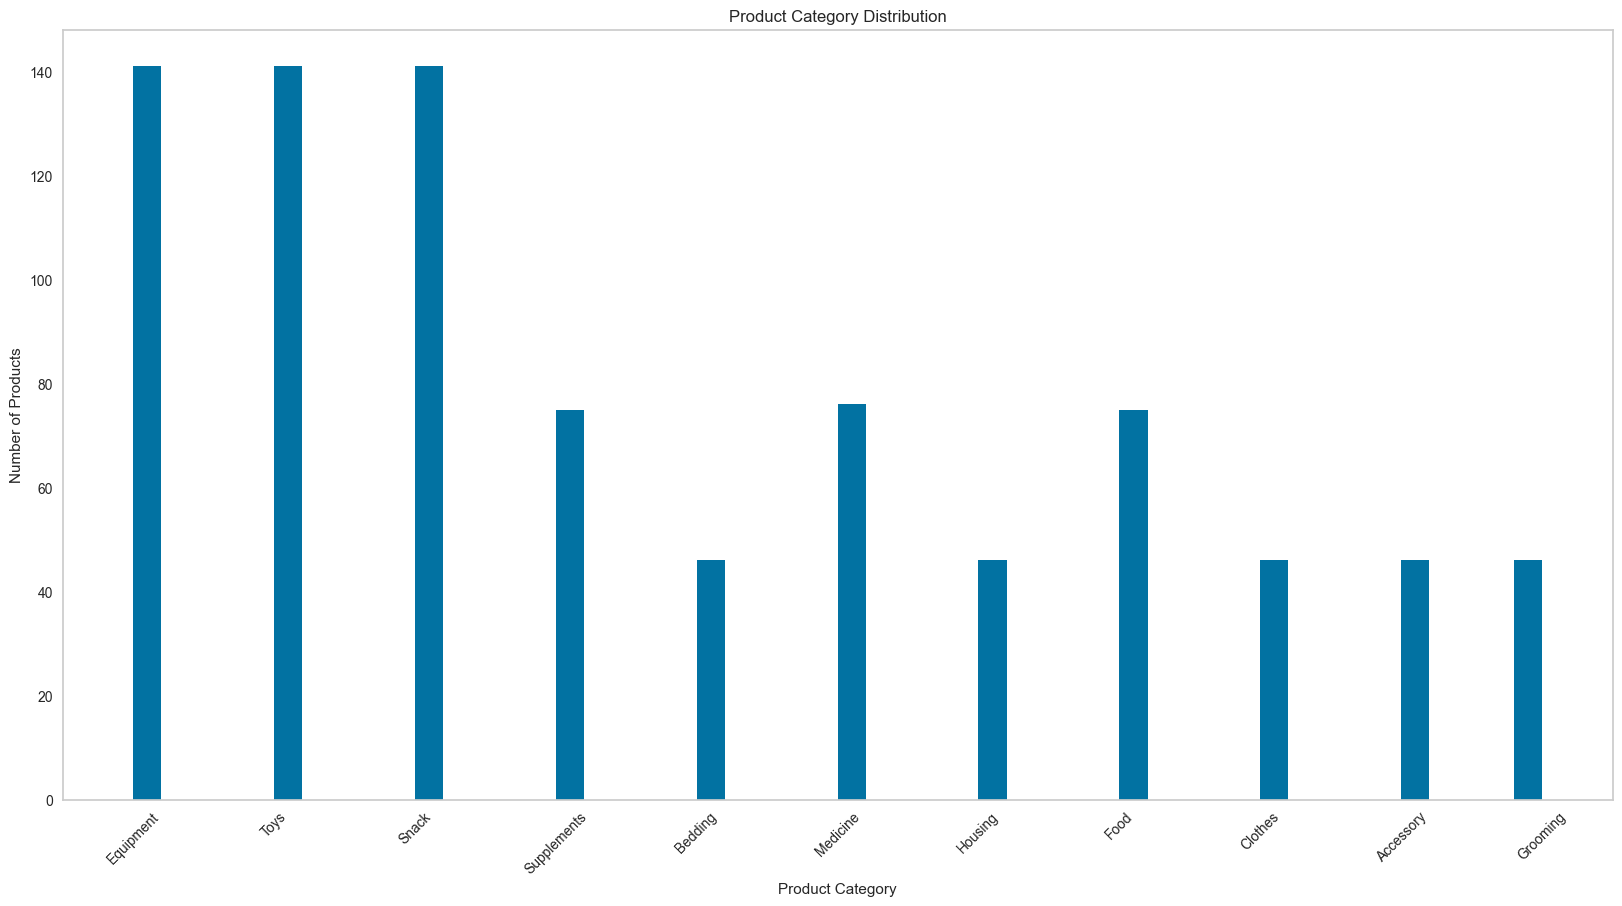

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

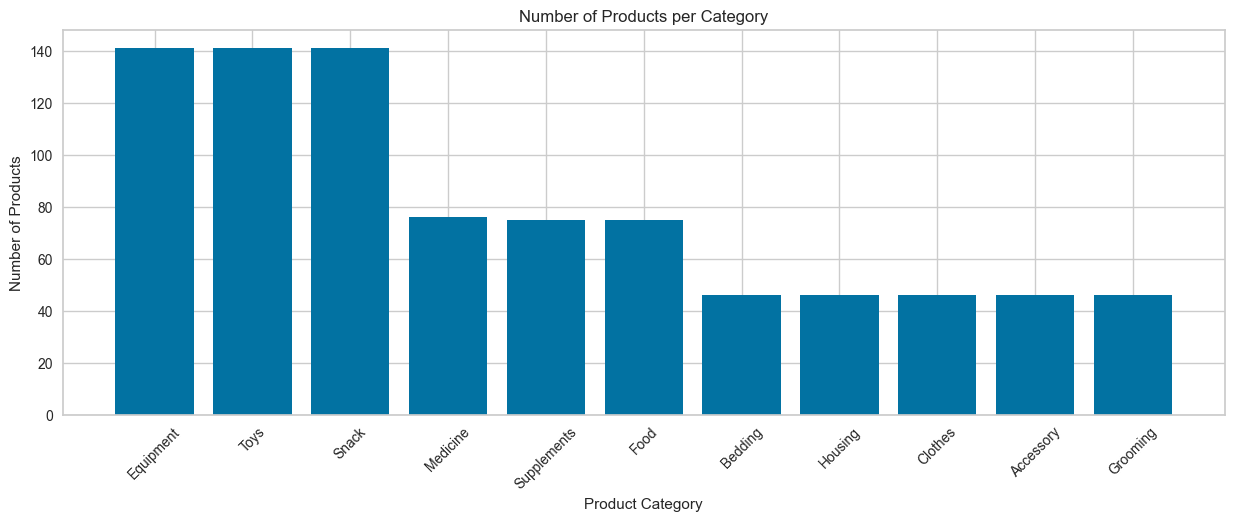

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

# Pre-processing

### Product Category Pre-processing

In [8]:
product_category = datasheet['product_category'].unique()
grouped_category_target = {
    'Lifestyle' : ['Equipment', 'Housing', 'Bedding'],
    'Food' : ['Food', 'Snack'],
    'Grooming' : ['Grooming'],
    'Medicine' : ['Medicine', 'Supplements'],
    'Clothes' : ['Clothes', 'Accessory'],
    'Toys' : ['Toys'],
}

def get_category(category):
    for key, value in grouped_category_target.items():
        if category in value:   return key
    print(f'Unknown category: {category}')
    return 'Others'

datasheet['product_category'] = datasheet['product_category'].apply(get_category)
print(datasheet['product_category'].unique())

['Lifestyle' 'Toys' 'Food' 'Medicine' 'Clothes' 'Grooming']


In [9]:
datasheet.head(10)

,product_category,sales,price,VAP,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,
5040,Lifestyle,123,7293,0,small,fish,7,1
4567,Toys,61,9304,1,small,cat,10,0
4237,Toys,218,8180,0,small,hamster,6,0
4364,Food,69,18559,1,large,dog,1,1
4184,Medicine,138,10283,1,large,dog,10,0
4609,Lifestyle,183,3969,1,large,cat,10,0
4380,Toys,79,13519,1,extra_small,dog,8,0
4389,Lifestyle,205,13078,0,large,cat,9,0
4697,Medicine,116,13701,0,small,cat,10,0


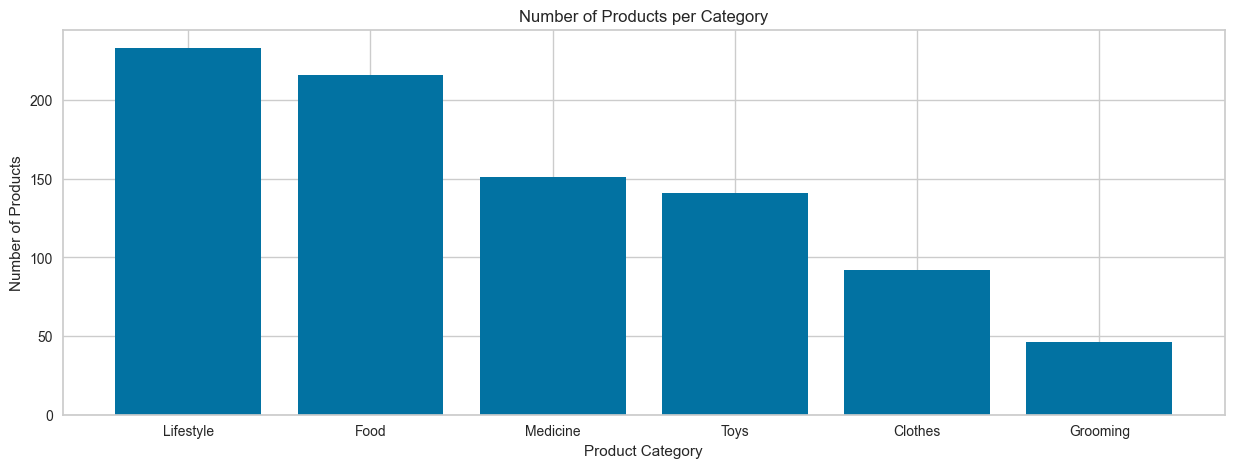

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index)
plt.grid(True)
plt.show()

In [11]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

datasheet['product_category'] = product_category

[Lifestyle]	->	[0]
[Toys]	->	[1]
[Food]	->	[2]
[Medicine]	->	[3]
[Clothes]	->	[4]
[Grooming]	->	[5]


### Pet Type Pre-processing

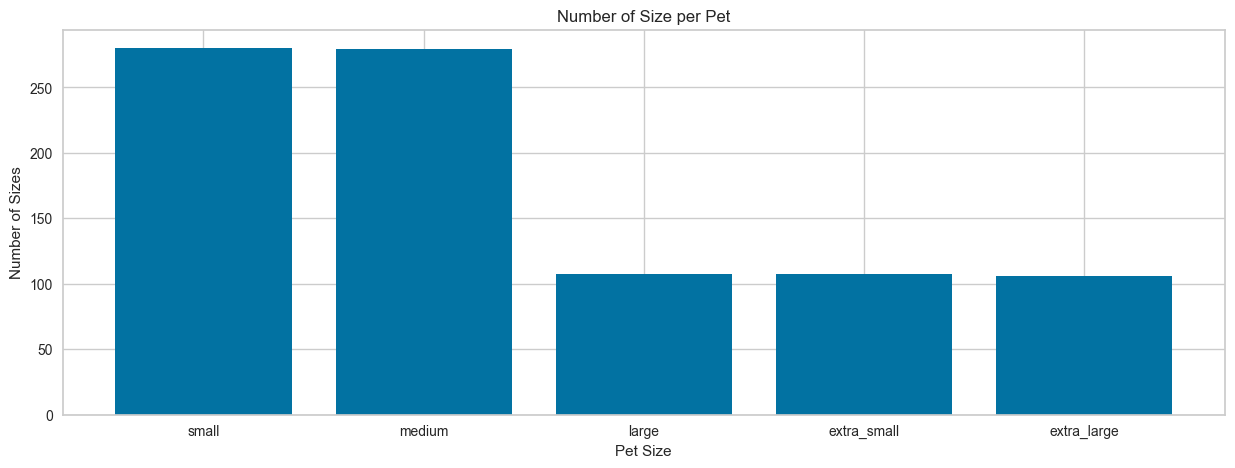

In [12]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['pet_size'].value_counts())), height=datasheet['pet_size'].value_counts())
plt.xlabel('Pet Size')
plt.ylabel('Number of Sizes')
plt.title('Number of Size per Pet')
plt.xticks(range(len(datasheet['pet_size'].value_counts())), datasheet['pet_size'].value_counts().index)
plt.grid(True)
plt.show()

In [13]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])

datasheet['pet_type'] = pet_type

[0]	->	fish
[1]	->	cat
[2]	->	hamster
[3]	->	dog
[4]	->	bird
[5]	->	rabbit


### Pet Size Pre-processing

In [14]:
org_pet_size = datasheet['pet_size'].to_list()
pet_size_uni = datasheet['pet_size'].unique()
pet_size_uni_code = [i for i in range(len(pet_size_uni))]
for i in range(len(pet_size_uni)):  print(f"{org_pet_size[i]}\t->\t{pet_size_uni_code[i]}")

pet_size = []
for i in range(len(org_pet_size)):
    for j in range(len(pet_size_uni)):
        if org_pet_size[i] == pet_size_uni[j]:
            pet_size.append(pet_size_uni_code[j])

datasheet['pet_size'] = pet_size

small	->	0
small	->	1
small	->	2
large	->	3
large	->	4


### Check for validate

In [15]:
datasheet.to_csv('./data/processed_dataset.csv')

# Train, Test(Validation) Split

In [16]:
print(datasheet.columns)
target = "product_category"

Index(['product_category', 'sales', 'price', 'VAP', 'pet_size', 'pet_type',
       'rating', 're_buy'],
      dtype='object')


In [17]:
y_data = datasheet[target].to_numpy()
X_data = datasheet.drop([target], axis=1).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 7)
y_data shape: (879,)


In [18]:
fig = px.scatter_3d(
    datasheet,
    x='pet_size',
    y='pet_type',
    z='product_category',
    color='product_category',
    opacity=0.7
)

fig.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, shuffle=True, stratify=y_data)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (615, 7)
y_train: (615,)
X_test: (264, 7)
y_test: (264,)


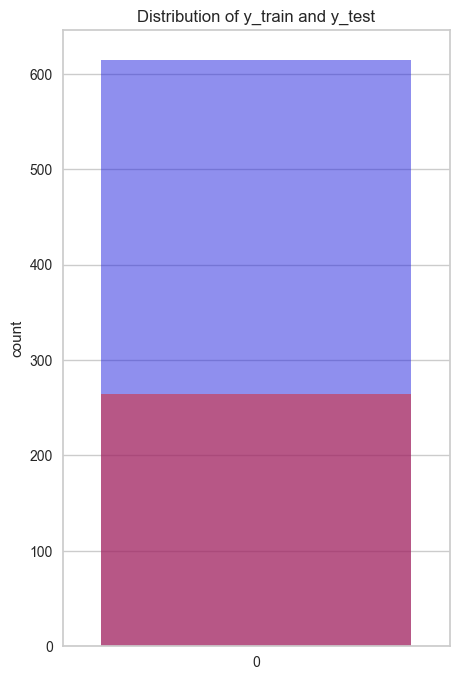

In [20]:
# X_train, y_train, X_test, y_test distribution plot
plt.figure(figsize=(5, 8))
plt.title('Distribution of y_train and y_test')
sns.countplot(y_train, color='blue', label='train', alpha=0.5)
sns.countplot(y_test, color='red', label='test', alpha=0.5)
plt.show()

In [21]:
datasheet.head(5)

,product_category,sales,price,VAP,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,
5040,0,123,7293,0,0,0,7,1
4567,1,61,9304,1,0,1,10,0
4237,1,218,8180,0,0,2,6,0
4364,2,69,18559,1,1,3,1,1
4184,3,138,10283,1,1,3,10,0


# autoML

In [21]:
s = setup(datasheet, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 8)"
4,Transformed data shape,"(879, 8)"
5,Transformed train set shape,"(615, 8)"
6,Transformed test set shape,"(264, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [22]:
exp = ClassificationExperiment()
exp.setup(data=datasheet, target=target)

,Description,Value
0,Session id,6762
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 8)"
4,Transformed data shape,"(879, 8)"
5,Transformed train set shape,"(615, 8)"
6,Transformed test set shape,"(264, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [23]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.2735,0.0000,0.2735,0.2003,0.2160,0.0386,0.0421,0.2010
lda,Linear Discriminant Analysis,0.2653,0.5474,0.2653,0.2275,0.2217,0.0365,0.0394,0.1850
dummy,Dummy Classifier,0.2651,0.5000,0.2651,0.0704,0.1112,0.0000,0.0000,0.2060
lr,Logistic Regression,0.2619,0.5165,0.2619,0.1797,0.1987,0.0232,0.0262,2.1340
nb,Naive Bayes,0.2555,0.5455,0.2555,0.2004,0.2118,0.0227,0.0251,0.1840
qda,Quadratic Discriminant Analysis,0.2342,0.5239,0.2342,0.2081,0.2129,0.0156,0.0162,0.2040
knn,K Neighbors Classifier,0.2310,0.4983,0.2310,0.2065,0.2081,0.0060,0.0060,0.2580
gbc,Gradient Boosting Classifier,0.2263,0.5434,0.2263,0.2143,0.2156,0.0156,0.0157,0.6140
svm,SVM - Linear Kernel,0.2196,0.0000,0.2196,0.0622,0.0930,-0.0006,-0.0059,0.2270
lightgbm,Light Gradient Boosting Machine,0.2181,0.5237,0.2181,0.2114,0.2106,0.0065,0.0065,0.4260


# Random Forest Classification

In [24]:
classifier = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, verbose=1, n_jobs=-1)
classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=1, warm_start=False)

In [25]:
y_pred = classifier.predict(X_test)
mse_loss = mean_squared_error(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.37      0.31        70
           1       0.21      0.19      0.20        42
           2       0.25      0.25      0.25        65
           3       0.26      0.27      0.26        45
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        14

    accuracy                           0.23       264
   macro avg       0.16      0.18      0.17       264
weighted avg       0.21      0.23      0.22       264



In [27]:
y_pred_train = classifier.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       163
           1       0.93      0.91      0.92        99
           2       0.89      0.93      0.91       151
           3       0.89      0.96      0.93       106
           4       0.98      0.86      0.92        64
           5       0.96      0.81      0.88        32

    accuracy                           0.91       615
   macro avg       0.92      0.89      0.91       615
weighted avg       0.91      0.91      0.91       615



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


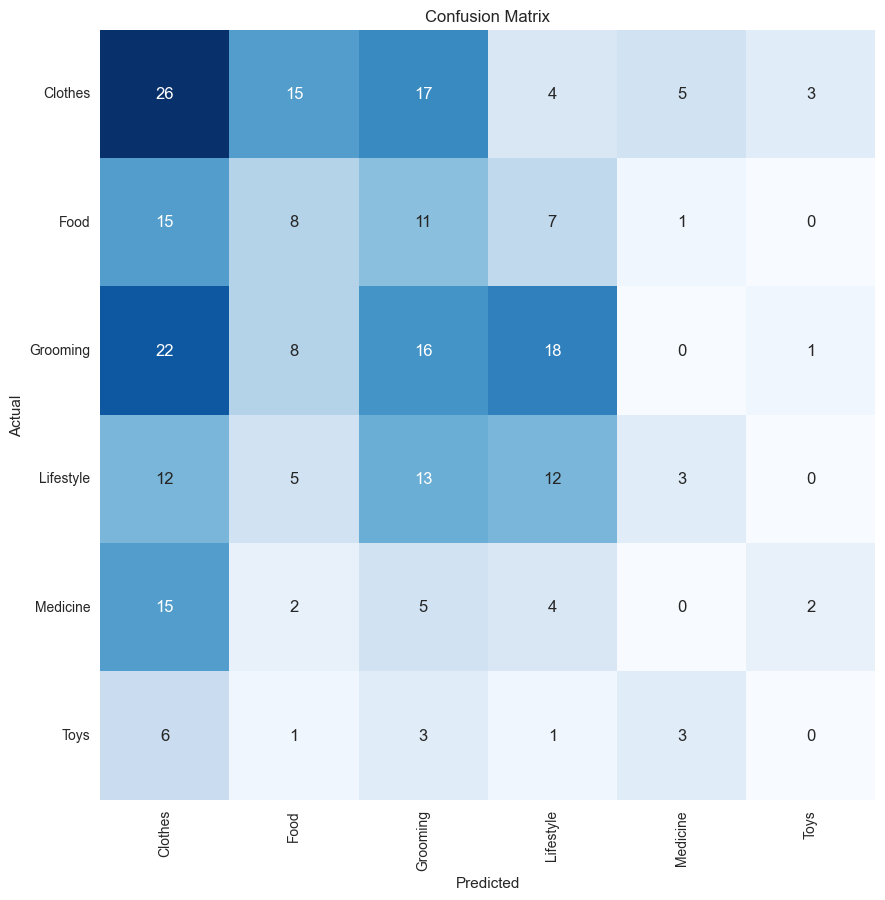

In [28]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

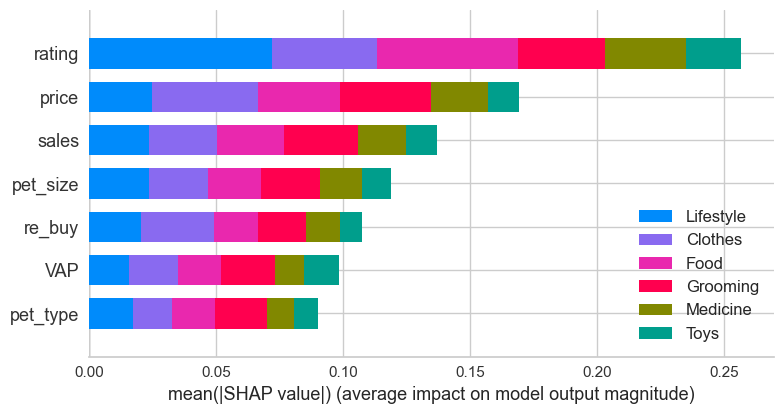

In [29]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Decision Tree Classification

In [30]:
classifier = DecisionTreeClassifier(
    ccp_alpha=0.002,
    max_depth=15,
    # class_weight=None, 
    # criterion='gini',
)

In [31]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)
print(f"Model score: {classifier.score(X_test, y_test)}")

MSE Loss:  4.143939393939394
Model score: 0.23484848484848486


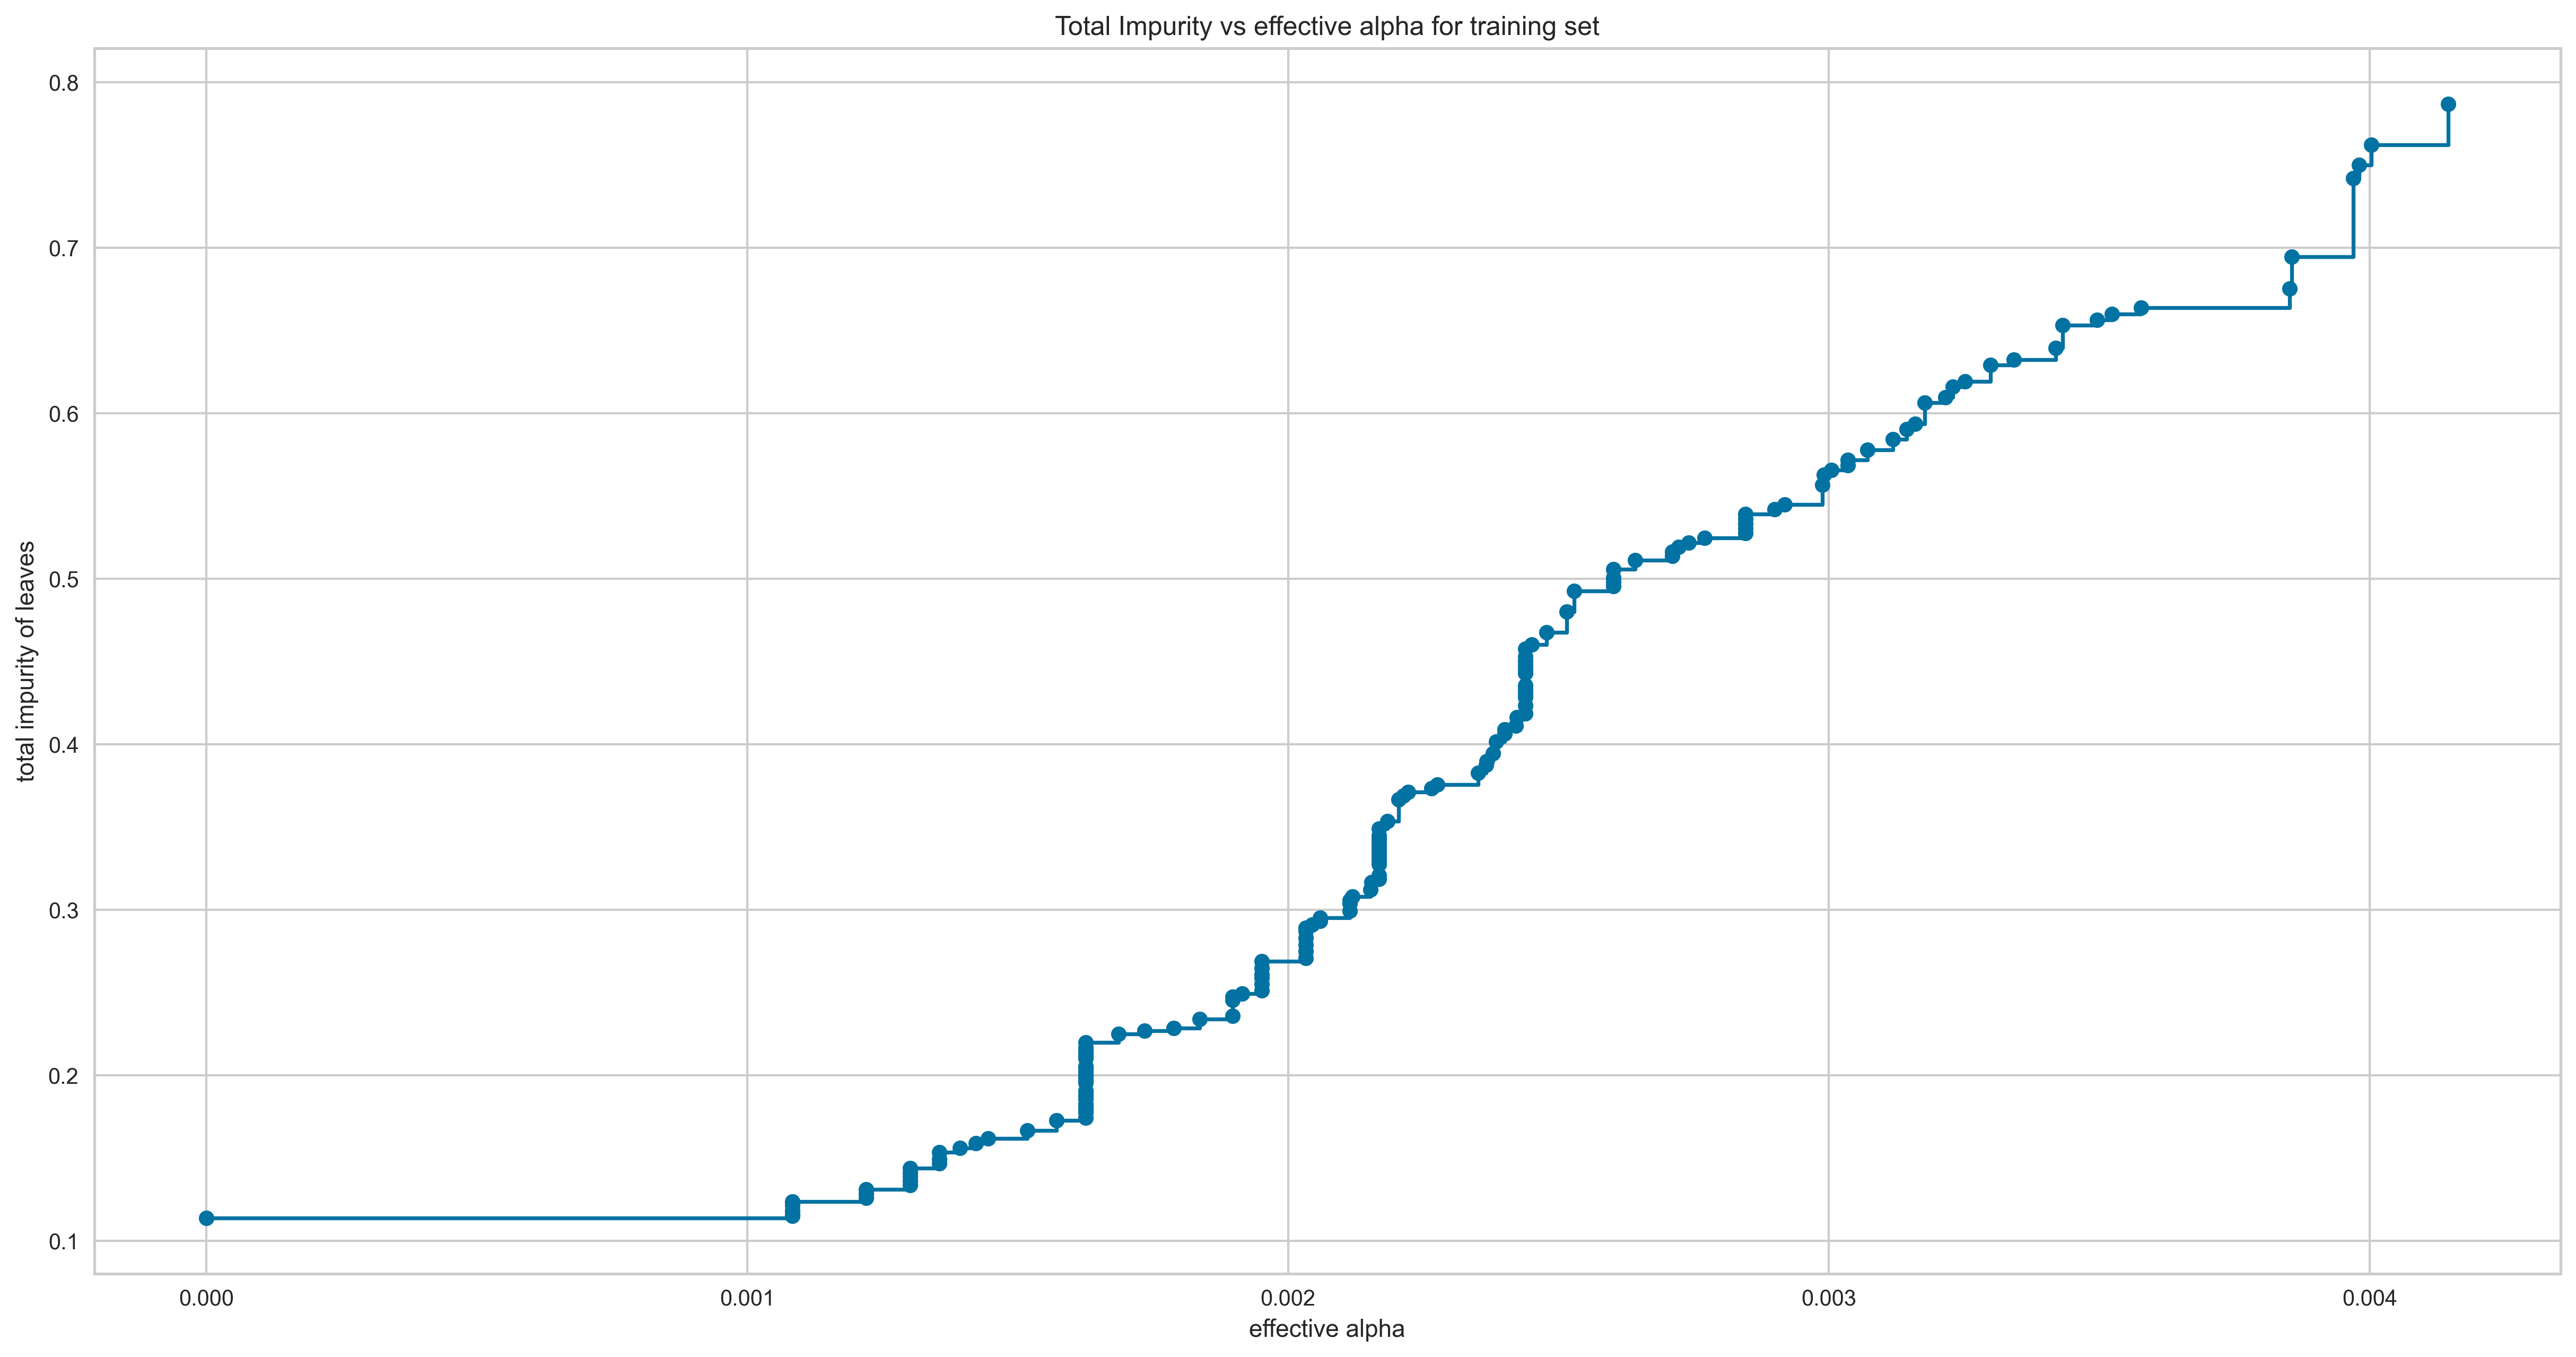

In [32]:
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs effective alpha for training set')
plt.show()

In [33]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.013478514097728822


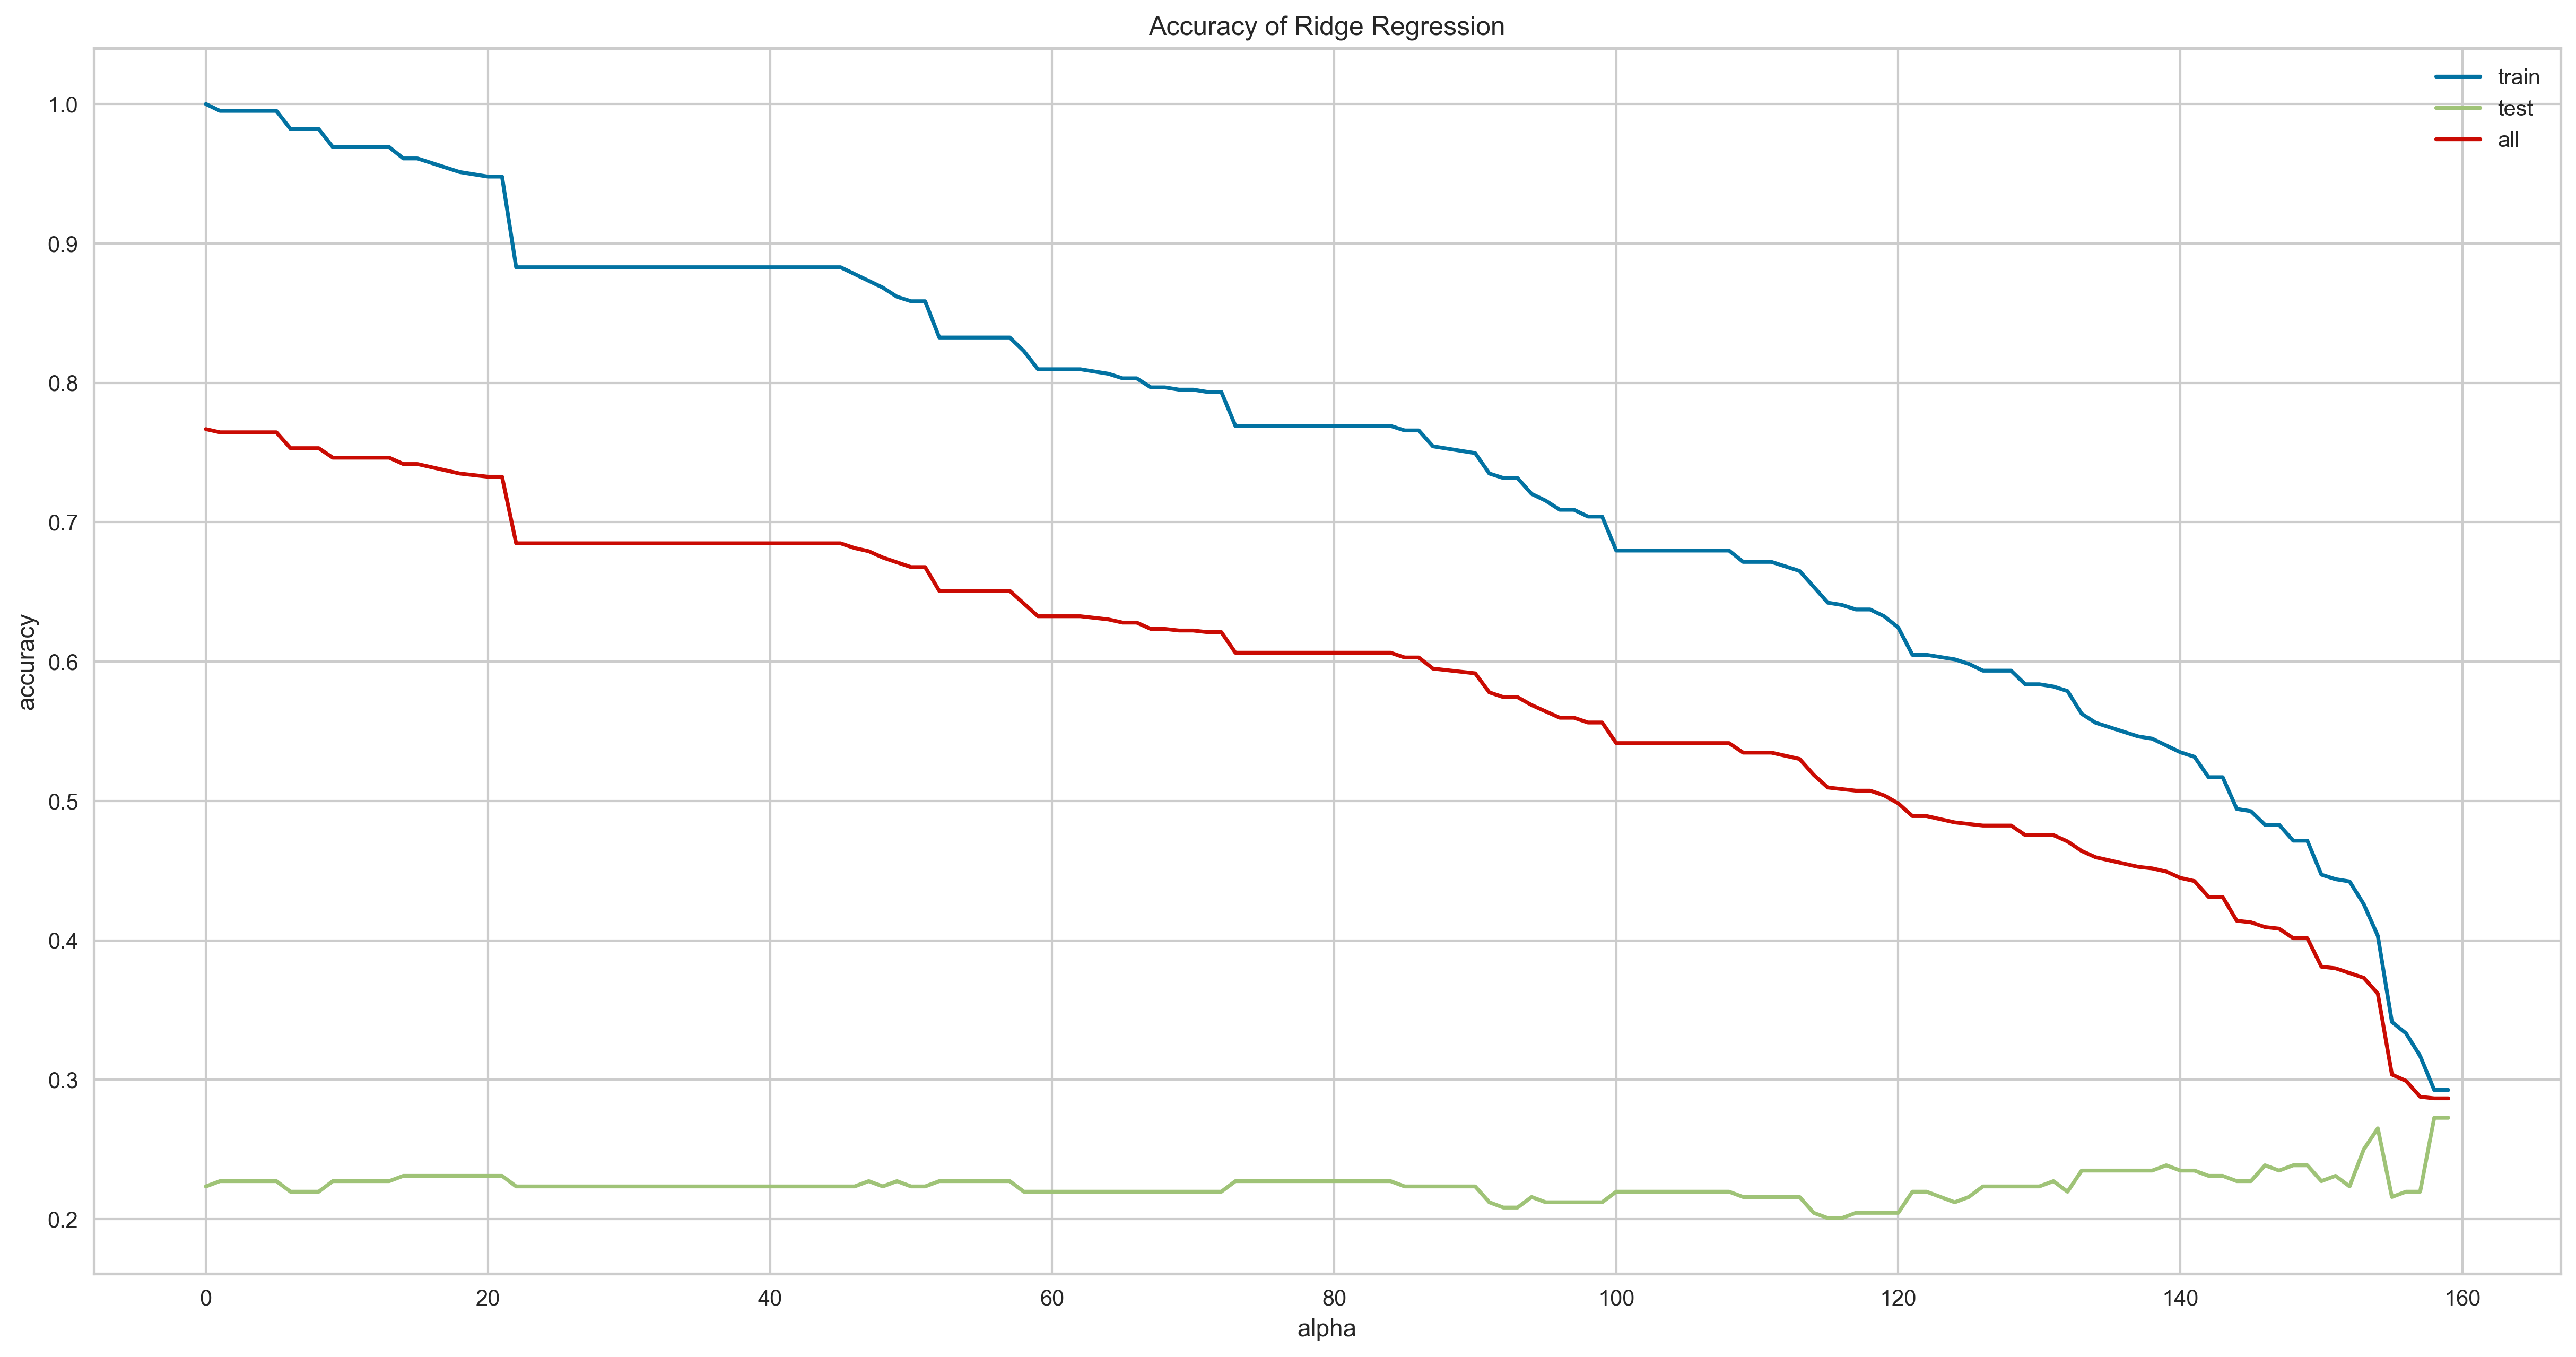

In [34]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
all_scores = [clf.score(X_data, y_data) for clf in clfs]

plt.figure(figsize=(20, 10), dpi=300)
plt.plot(train_scores, label='train')
plt.plot(test_scores, label='test')
plt.plot(all_scores, label='all')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Accuracy of Ridge Regression')
plt.legend()
plt.show()

In [35]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.26      0.33      0.29        70
        Food       0.18      0.21      0.20        42
    Grooming       0.22      0.15      0.18        65
   Lifestyle       0.30      0.33      0.32        45
    Medicine       0.23      0.18      0.20        28
        Toys       0.00      0.00      0.00        14

    accuracy                           0.23       264
   macro avg       0.20      0.20      0.20       264
weighted avg       0.23      0.23      0.23       264



In [36]:
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.28      0.80      0.41       163
        Food       0.00      0.00      0.00        99
    Grooming       0.00      0.00      0.00       151
   Lifestyle       0.34      0.47      0.39       106
    Medicine       0.00      0.00      0.00        64
        Toys       0.00      0.00      0.00        32

    accuracy                           0.29       615
   macro avg       0.10      0.21      0.13       615
weighted avg       0.13      0.29      0.18       615



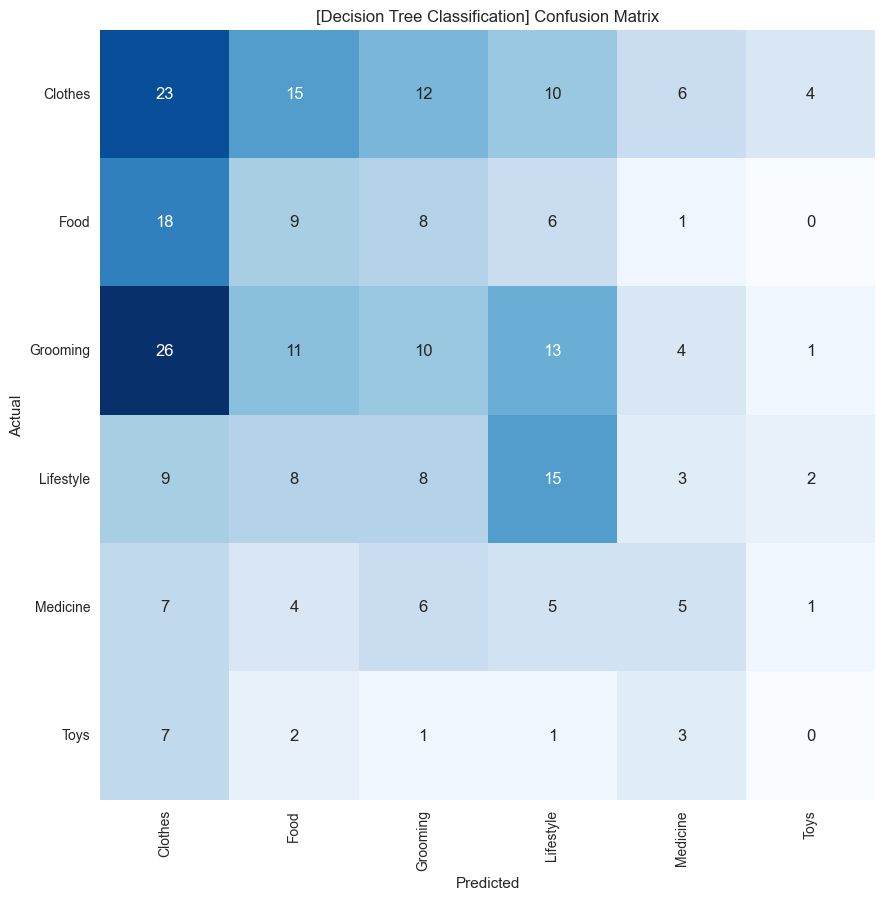

In [37]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('[Decision Tree Classification] Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

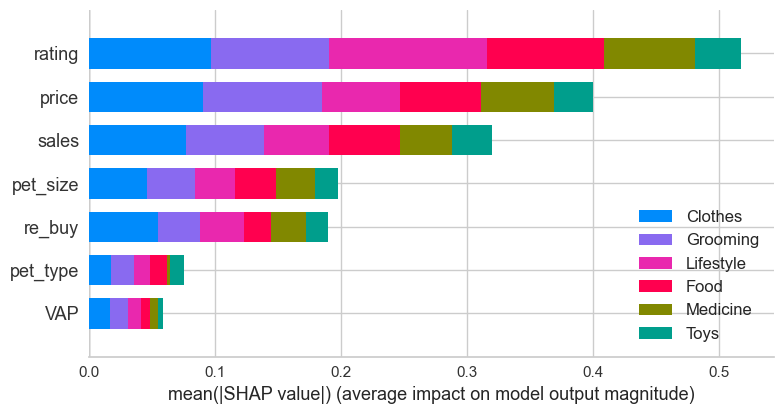

In [38]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Dummy Classifier

In [39]:
dummy_classifier = DummyClassifier(strategy="uniform", random_state=42)
dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Accuracy: 0.17803030303030304
Mean Squared Error: 5.693181818181818


In [40]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.29      0.20      0.24        70
        Food       0.16      0.14      0.15        42
    Grooming       0.29      0.20      0.24        65
   Lifestyle       0.16      0.20      0.18        45
    Medicine       0.05      0.07      0.06        28
        Toys       0.07      0.21      0.11        14

    accuracy                           0.18       264
   macro avg       0.17      0.17      0.16       264
weighted avg       0.21      0.18      0.19       264



In [41]:
y_pred_train = dummy_classifier.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.27      0.19      0.22       163
        Food       0.17      0.16      0.16        99
    Grooming       0.19      0.12      0.15       151
   Lifestyle       0.19      0.22      0.21       106
    Medicine       0.14      0.22      0.17        64
        Toys       0.01      0.03      0.02        32

    accuracy                           0.17       615
   macro avg       0.16      0.16      0.15       615
weighted avg       0.20      0.17      0.18       615



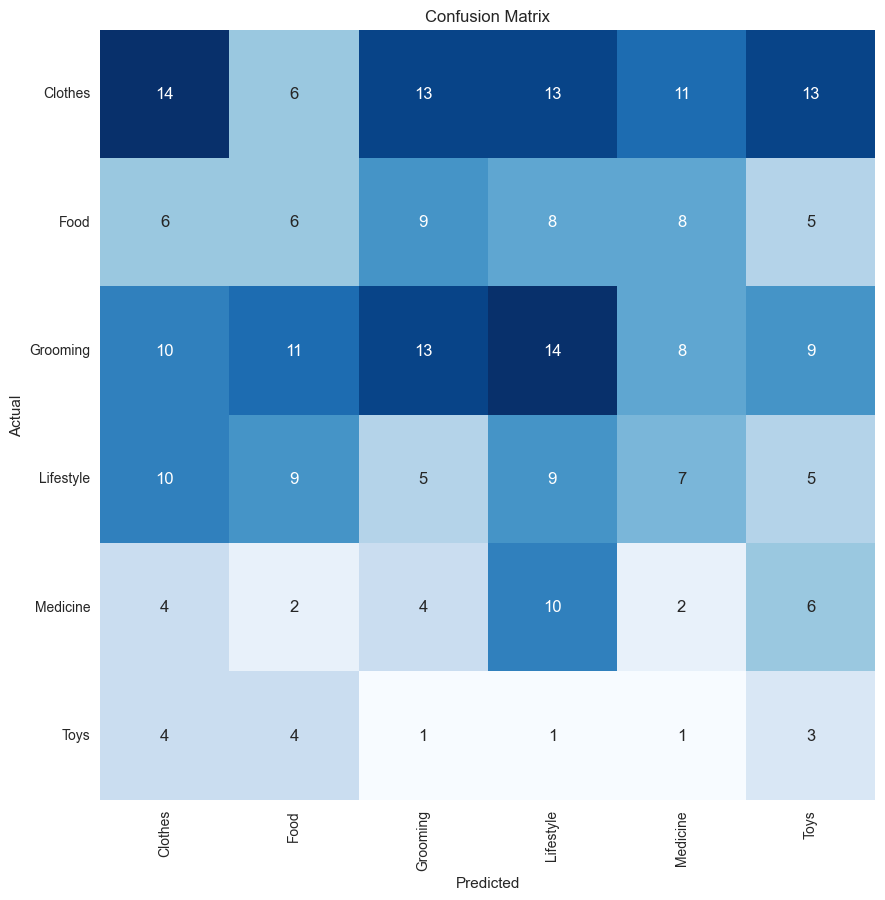

In [42]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

In [45]:
with open("./export/exported_dummy_classifier.pkl", "wb") as f:
    saved_model = pickle.dump(dummy_classifier, f)

# KNN in 3 dimension

In [46]:
knn = KNeighborsClassifier(n_neighbors=6, p=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='uniform')

In [47]:
y_pred = knn.predict(X_test)
print(f"Model score: {knn.score(X_test, y_test)}")

Model score: 0.2840909090909091


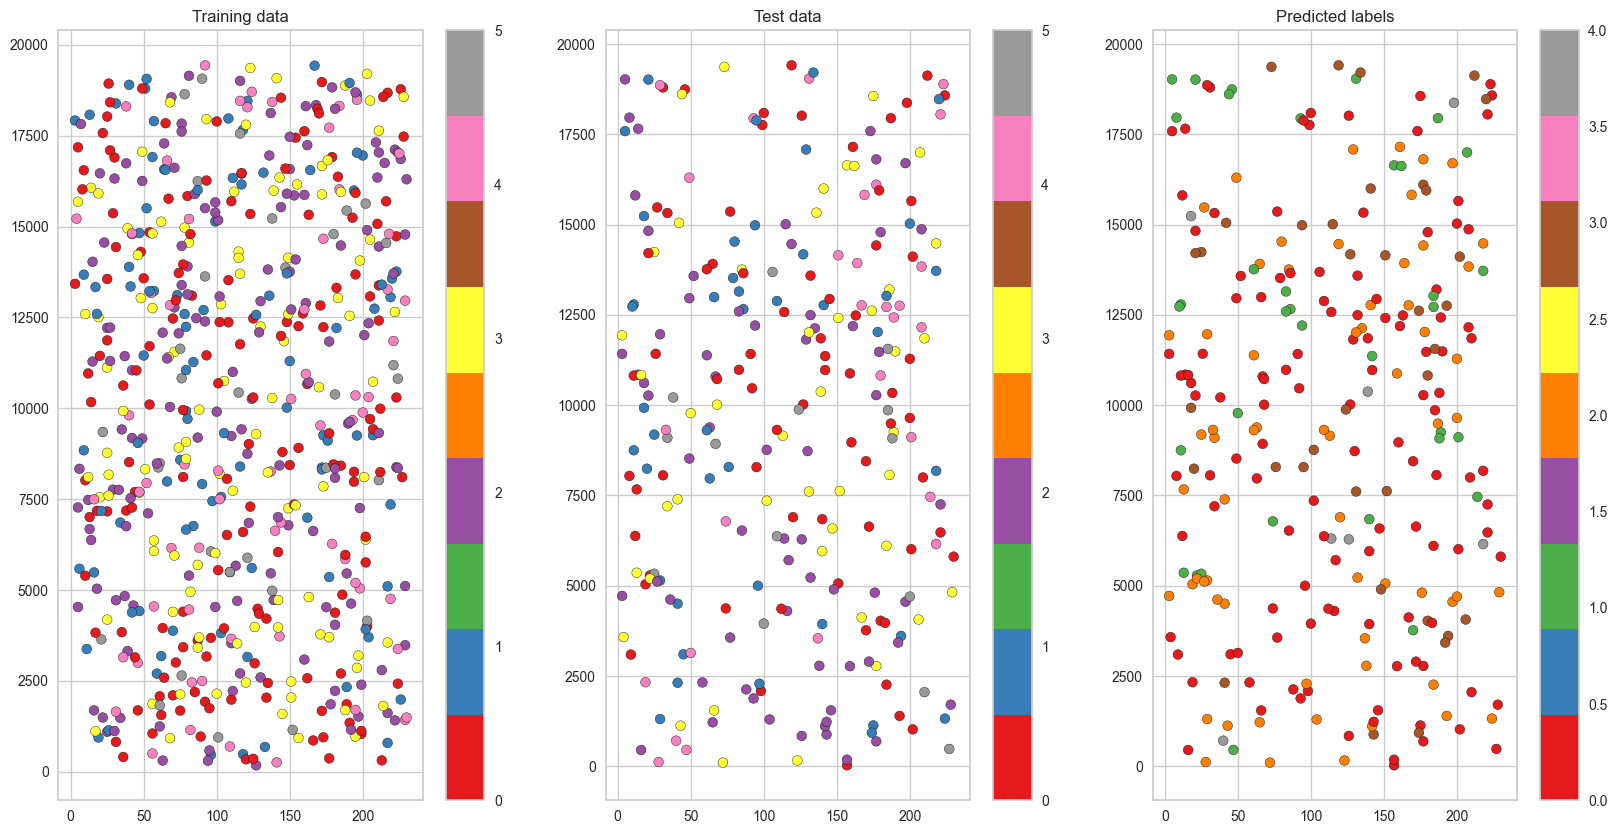

In [48]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title("Training data")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Test data")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Predicted labels")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.Set1, edgecolor='k')
plt.colorbar()

plt.show()

In [49]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.33      0.57      0.42        70
        Food       0.23      0.19      0.21        42
    Grooming       0.27      0.26      0.26        65
   Lifestyle       0.22      0.18      0.20        45
    Medicine       0.29      0.07      0.11        28
        Toys       0.00      0.00      0.00        14

    accuracy                           0.28       264
   macro avg       0.22      0.21      0.20       264
weighted avg       0.26      0.28      0.25       264



In [50]:
y_pred_train = knn.predict(X_train)
print(classification_report(y_train, y_pred_train, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.42      0.74      0.53       163
        Food       0.40      0.37      0.39        99
    Grooming       0.50      0.48      0.49       151
   Lifestyle       0.48      0.28      0.36       106
    Medicine       0.32      0.09      0.14        64
        Toys       0.40      0.06      0.11        32

    accuracy                           0.44       615
   macro avg       0.42      0.34      0.34       615
weighted avg       0.43      0.44      0.41       615



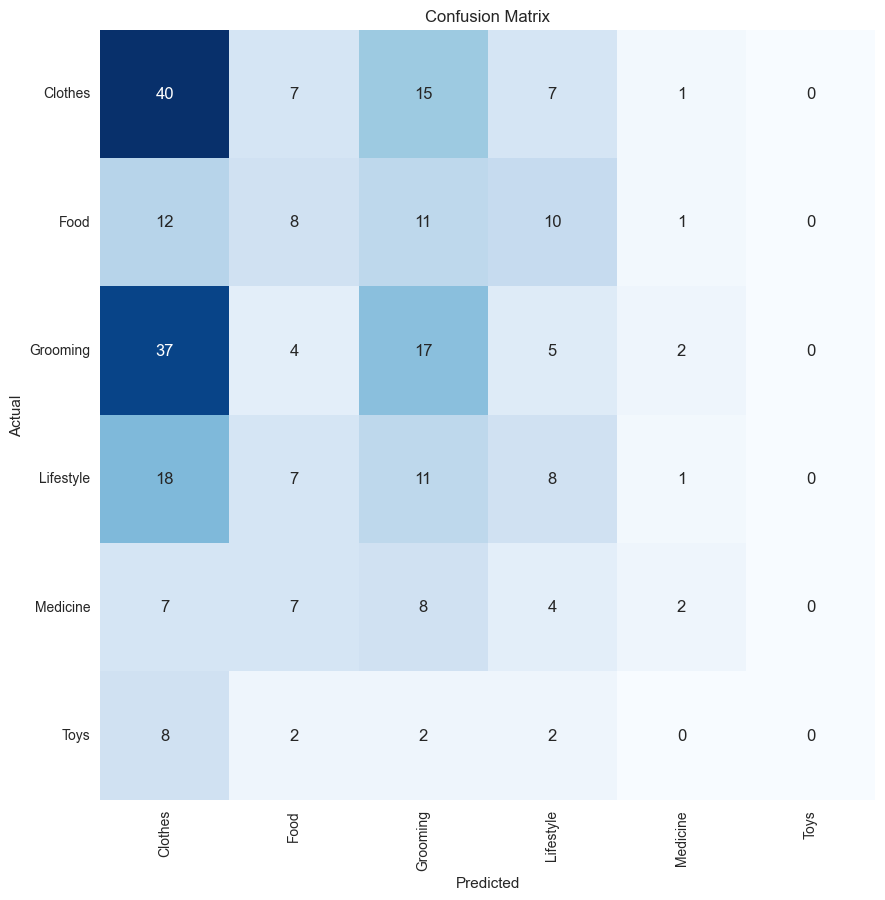

In [51]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()